In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/27-class-sign-language-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/27-class-sign-language-dataset/Y.npy
/kaggle/input/27-class-sign-language-dataset/X.npy


In [2]:
#Load features (images) and labels
X = np.load('/kaggle/input/27-class-sign-language-dataset/X.npy')
y = np.load('/kaggle/input/27-class-sign-language-dataset/Y.npy')

In [3]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import backend as K
from keras.applications.imagenet_utils import preprocess_input
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


2025-05-03 20:36:06.250835: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746304566.572869      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746304566.662418      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
def resize_images(images, target_size=(128,128)):
    resized_images = []
    for img in images:
        resized = cv2.resize(img, target_size)
        resized_images.append(resized)
    return np.array(resized_images)

X_resized = resize_images(X)

In [5]:
images = X.astype('float32')
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(y.reshape(-1))
y_categorical = to_categorical(labels)

In [6]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,  
    fill_mode='nearest'
)
X_train, X_val, y_train, y_val = train_test_split(
    X_resized, y_categorical, test_size=0.2, random_state=42
)
# Create generator for training
train_generator = train_datagen.flow(
    x=X_train,
    y=y_train,
    batch_size=32,
    shuffle=True
)

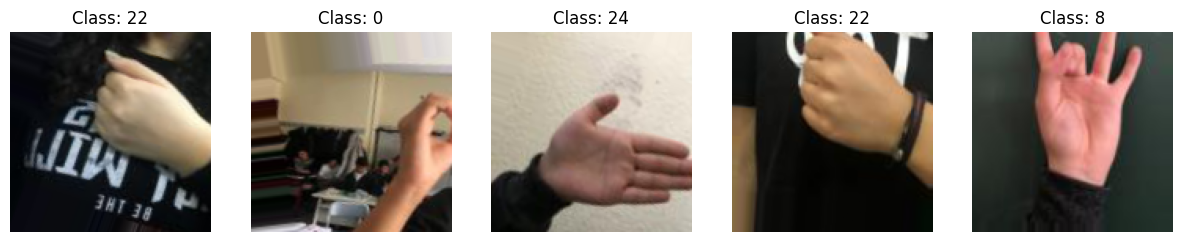

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_samples(images, labels, num_samples=5, augmentation_type="Original"):
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        
        # For grayscale images (single channel)
        if images[i].shape[-1] == 1:
            plt.imshow(images[i].squeeze(), cmap='gray')
        else:
            plt.imshow(images[i])
            
        plt.title(f"{augmentation_type}\nClass: {np.argmax(labels[i])}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt

# Generate a batch of augmented images
aug_images, aug_labels = next(train_generator)  # Correct syntax

# Plot samples
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    
    # For grayscale images (1 channel)
    if aug_images[i].shape[-1] == 1:
        plt.imshow(aug_images[i].squeeze(), cmap='gray')
    else:
        plt.imshow(aug_images[i])
    
    plt.title(f"Class: {np.argmax(aug_labels[i])}")
    plt.axis('off')
plt.show()

In [8]:
# Create a validation generator using ImageDataGenerator
val_datagen = ImageDataGenerator() # No augmentation 
val_generator = val_datagen.flow(
    x=X_val,
    y=y_val,
    batch_size=32,
    shuffle=False 
)

In [9]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_inceptionv3_model(input_shape, num_classes):
    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Finetune last 20 layers
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model, base_model

# Input shape and class count
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

# Build and compile model
model, base_model = build_inceptionv3_model(input_shape, num_classes)
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
]

# Training
history_top = model.fit(
    train_generator,
    epochs=25,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

# Evaluation
loss, accuracy = model.evaluate(X_val, y_val)
print(f"\nFinal Validation Accuracy: {accuracy*100:.2f}%")


I0000 00:00:1746304590.837311      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746304590.837938      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746304609.458862      99 service.cc:148] XLA service 0x786668005100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746304609.460062      99 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746304609.460088      99 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746304611.579699      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/570 ━━━━━━━━━━━━━━━━━━━━ 3:54:17 25s/step - accuracy: 0.0312 - loss: 3.5638

I0000 00:00:1746304619.238996      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


570/570 ━━━━━━━━━━━━━━━━━━━━ 107s 145ms/step - accuracy: 0.1466 - loss: 2.9767 - val_accuracy: 0.4403 - val_loss: 1.7186 - learning_rate: 1.0000e-04
Epoch 2/25
570/570 ━━━━━━━━━━━━━━━━━━━━ 70s 121ms/step - accuracy: 0.3535 - loss: 2.0226 - val_accuracy: 0.5179 - val_loss: 1.4454 - learning_rate: 1.0000e-04
Epoch 3/25
570/570 ━━━━━━━━━━━━━━━━━━━━ 69s 119ms/step - accuracy: 0.4268 - loss: 1.7607 - val_accuracy: 0.5464 - val_loss: 1.2994 - learning_rate: 1.0000e-04
Epoch 4/25
570/570 ━━━━━━━━━━━━━━━━━━━━ 69s 119ms/step - accuracy: 0.4603 - loss: 1.6390 - val_accuracy: 0.5975 - val_loss: 1.1841 - learning_rate: 1.0000e-04
Epoch 5/25
570/570 ━━━━━━━━━━━━━━━━━━━━ 69s 120ms/step - accuracy: 0.4880 - loss: 1.5578 - val_accuracy: 0.6084 - val_loss: 1.1189 - learning_rate: 1.0000e-04
Epoch 6/25
570/570 ━━━━━━━━━━━━━━━━━━━━ 69s 119ms/step - accuracy: 0.5179 - loss: 1.4747 - val_accuracy: 0.6314 - val_loss: 1.0664 - learning_rate: 1.0000e-04
Epoch 7/25
570/570 ━━━━━━━━━━━━━━━━━━━━ 68s 118ms/step -

/tmp/ipykernel_31/3131026758.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


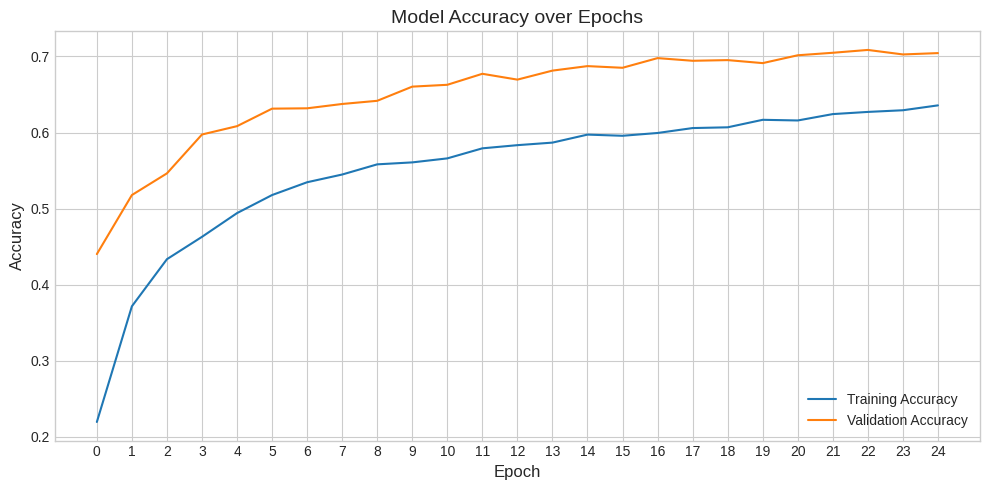

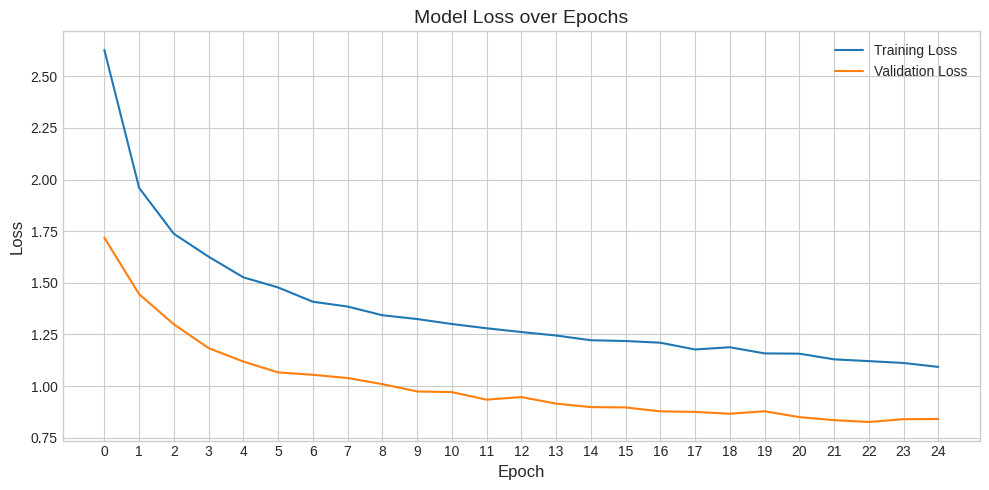

In [10]:
plt.style.use('seaborn-whitegrid')  

def plot_training_history(history):
    epochs = range(len(history.history['accuracy']))

    # Accuracy Plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy over Epochs', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xticks(epochs)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Loss Plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss over Epochs', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.xticks(epochs)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function
plot_training_history(history_top)

In [17]:
pip install lime

Note: you may need to restart the kernel to use updated packages.


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━

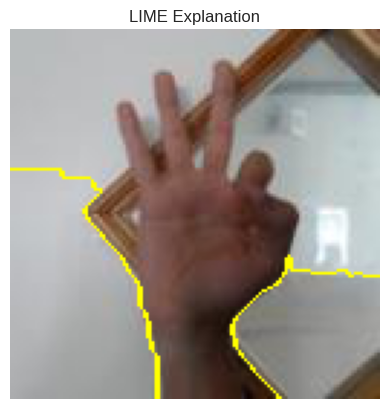

In [21]:

img = X_val[0]  

# If the model expects 4D input (batch of images), ensure correct shape
if len(img.shape) == 3:
    img_batch = np.expand_dims(img, axis=0)
else:
    img_batch = img

# Run LIME
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image=img.astype('double'),
    classifier_fn=lambda x: model.predict(x),
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# Visualize
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    hide_rest=False
)

plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation")
plt.axis('off')
plt.show()


In [27]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

misclassified_indices = np.where(y_pred_classes != y_true_classes)[0]

143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step


In [23]:
!pip install SHAP 

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

PartitionExplainer explainer: 2it [00:14, 14.95s/it]               


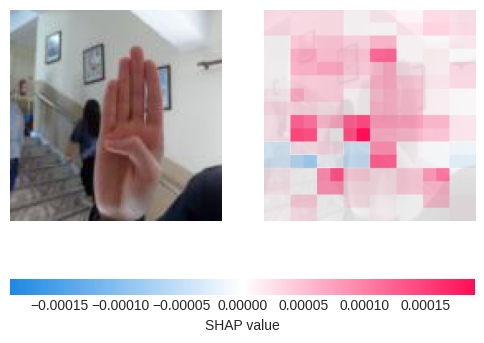

In [28]:
import shap
from shap.maskers import Image
import numpy as np


test_images = X_val[misclassified_indices[:1]]  

preds = model.predict(test_images)
pred_class = np.argmax(preds[0])  
masker = Image("blur(128,128)", test_images[0].shape)

explainer = shap.Explainer(
    lambda x: model.predict(x)[:, pred_class],  # target one class
    masker
)
shap_values = explainer(test_images)

shap.plots.image(shap_values)



In [29]:
import numpy as np
import matplotlib.pyplot as plt

def feature_ablation_heatmap(image, model, class_idx=None, patch_size=20):
    img = image.copy()
    h, w, c = img.shape
    n_patches_y = h // patch_size
    n_patches_x = w // patch_size
    heatmap = np.zeros((n_patches_y, n_patches_x))
    orig_pred = model.predict(img[None])[0]
    
    if class_idx is None:
        class_idx = np.argmax(orig_pred)
    orig_conf = orig_pred[class_idx]

    for i in range(n_patches_y):
        for j in range(n_patches_x):
            occluded = img.copy()
            y_start = i * patch_size
            x_start = j * patch_size

            
            occluded[y_start:y_start+patch_size, x_start:x_start+patch_size, :] = 0.5
            occl_pred = model.predict(occluded[None])[0][class_idx]
            delta = orig_conf - occl_pred
            heatmap[i, j] = delta

    
    heatmap_resized = np.kron(heatmap, np.ones((patch_size, patch_size)))
    heatmap_resized = heatmap_resized[:h, :w]

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.imshow(heatmap_resized, cmap='hot', alpha=0.5)
    plt.axis('off')
    plt.title("Feature Ablation Map")
    plt.colorbar(label="Drop in confidence")
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

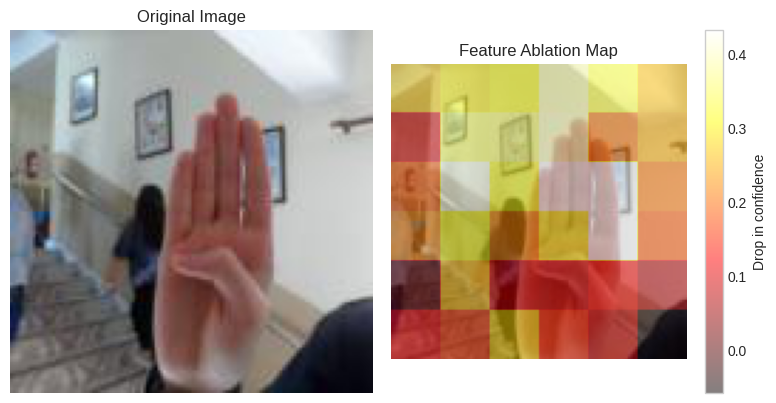

In [30]:

feature_ablation_heatmap(test_images[0], model)